In [38]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

### 손글씨 데이터에다가 노이즈를 일부러 만들어서 오토인코더로 복원해보기

In [39]:
# 이미지에 가우스 노이즈를 더해주는 함수
def gaussia_noise(x, scale=0.8):
    gaussia_data_x = x+np.random.normal(loc = 0, scale = scale, size = x.shape)
    # 이제 이미지의 픽셀값을 넘어서는 것들 고정해줘야한다. 
    gaussia_data_x = np.clip(gaussia_data_x, 0, 1) # 최대 최소를 벗어나지 않게 해준다.
    gaussia_data_x = torch.tensor(gaussia_data_x)
    gaussia_data_x = gaussia_data_x.type(torch.FloatTensor)
    return gaussia_data_x


train_data = MNIST(root = './', train = True, download = True, transform = ToTensor())
test_data = MNIST(root = './', train = False, download = True, transform = ToTensor())


C:\Users\user\miniconda3\envs\meta\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


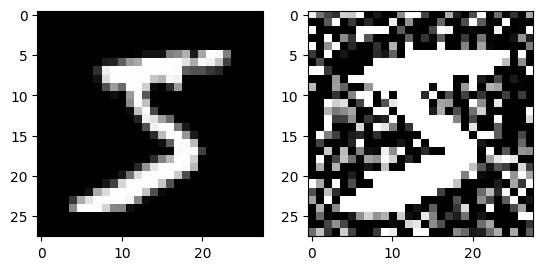

In [40]:
img = train_data.data[0]
noise_img = gaussian_noise(img)

plt.subplot(1,2,1)
plt.imshow(img,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(noise_img,cmap='gray')
plt.show()

In [41]:
from torch.utils.data.dataset import Dataset

class Denoising(Dataset):
    def __init__(self):

        self.mnist = MNIST(root='./',train=True,download=True,transform=ToTensor())
        self.data = []

        for temp in range(len(self.mnist)):
            noise_input = gaussian_noise(self.mnist.data[temp])
            input_tensor = torch.tensor(noise_input)
            self.data.append(torch.unsqueeze(input_tensor,dim=0))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        data = self.data[i]

        label = self.mnist.data[i]/255

        return data,label

## 학습시키는 모델 구현 

In [42]:
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self,in_channel, out_channel, hidden_dim):
        super(BasicBlock,self).__init__()

        self.conv1 = nn.Conv2d(in_channel,
                               hidden_dim,
                               kernel_size=3,
                               padding=1
                               )

        self.conv2 = nn.Conv2d(hidden_dim,
                               out_channel,
                               kernel_size=3,
                               padding=1
                               )

        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)

        return x


### 인코더 만들기

In [43]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()

        self.conv1 = BasicBlock(1,16,16)
        self.conv2 = BasicBlock(16,8,8)

        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self,x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)

        return x

### 인코더는 특징을 압축해주는 것.
- 총 8개의 특징을 압축을 해준다.

In [45]:
from torchsummary import summary
encoder = Encoder().cuda()

summary(encoder,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 16, 28, 28]           2,320
              ReLU-4           [-1, 16, 28, 28]               0
        BasicBlock-5           [-1, 16, 28, 28]               0
         AvgPool2d-6           [-1, 16, 14, 14]               0
            Conv2d-7            [-1, 8, 14, 14]           1,160
              ReLU-8            [-1, 8, 14, 14]               0
            Conv2d-9            [-1, 8, 14, 14]             584
             ReLU-10            [-1, 8, 14, 14]               0
       BasicBlock-11            [-1, 8, 14, 14]               0
        AvgPool2d-12              [-1, 8, 7, 7]               0
Total params: 4,224
Trainable params: 4,224
Non-trainable params: 0
-----------------------------------

In [46]:
nn.ConvTranspose2d (kernerl = 2, stride=2)
(SIZE - 1) * stride - 2*padding + kernel_size
(7-1) * 2 - 2*0 + 2 = 14

SyntaxError: can't assign to operator (3279278765.py, line 3)

### 디코더 만들기

In [47]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.conv1 = BasicBlock(8,8,8)
        self.conv2 = BasicBlock(8,16,16)
        self.conv3 = nn.Conv2d(16,1, kernel_size = 3, padding = 1)
        # 풀링 쓰는거 반대로
        self.upsample1 = nn.ConvTranspose2d(8,8,kernel_size = 2, stride = 2)
        self.upsample2 = nn.ConvTranspose2d(16,16,kernel_size = 2, stride = 2)
    
    def forward(self, x):
        x = self.conv1(x) # 채널 수가 8,7,7 짜리가
        x = self.upsample1(x)
        x = self.conv2(x)
        x = self.upsample2(x)
        x = self.conv3(x) # 1,28,28의 이미지로 복원이 된다.
        return x

In [50]:
decoder = Decoder().cuda()
summary(decoder,input_size=(8,7,7))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 8, 7, 7]             584
              ReLU-2              [-1, 8, 7, 7]               0
            Conv2d-3              [-1, 8, 7, 7]             584
              ReLU-4              [-1, 8, 7, 7]               0
        BasicBlock-5              [-1, 8, 7, 7]               0
   ConvTranspose2d-6            [-1, 8, 14, 14]             264
            Conv2d-7           [-1, 16, 14, 14]           1,168
              ReLU-8           [-1, 16, 14, 14]               0
            Conv2d-9           [-1, 16, 14, 14]           2,320
             ReLU-10           [-1, 16, 14, 14]               0
       BasicBlock-11           [-1, 16, 14, 14]               0
  ConvTranspose2d-12           [-1, 16, 28, 28]           1,040
           Conv2d-13            [-1, 1, 28, 28]             145
Total params: 6,105
Trainable params: 6

### 학습

In [51]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x) # 출력되는건 1,28,28 이기에 원본은 채널이없다.
        x = torch.squeeze(x) # 28,28
        
        return x

In [52]:
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'

trainset = Denoising()
train_loader = DataLoader(trainset, batch_size=32)

model = Model().to(device)
optim = Adam(model.parameters(), lr = 1e-3)



C:\Users\user\miniconda3\envs\meta\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
C:\Users\user\miniconda3\envs\meta\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


In [54]:
import tqdm 

for epoch in range(20):
    for data, lable in tqdm.tqdm(train_loader):
        optim.zero_grad()
        pred = model(data.to(device))
        
        loss = nn.MSELoss()(torch.squeeze(pred), lable.to(device))
        loss.backward()
        optim.step()
        
    print(f'epoch : {epoch+1} loss : {loss.item()}')

100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:23<00:00, 79.12it/s]


epoch : 1 loss : 0.013263436034321785


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:23<00:00, 80.14it/s]


epoch : 2 loss : 0.011203472502529621


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:23<00:00, 80.21it/s]


epoch : 3 loss : 0.010516543872654438


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:23<00:00, 79.76it/s]


epoch : 4 loss : 0.01015483308583498


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:22<00:00, 82.49it/s]


epoch : 5 loss : 0.010218111798167229


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:22<00:00, 83.73it/s]


epoch : 6 loss : 0.010005347430706024


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:24<00:00, 77.90it/s]


epoch : 7 loss : 0.009490875527262688


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:27<00:00, 67.90it/s]


epoch : 8 loss : 0.009020158089697361


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:27<00:00, 68.78it/s]


epoch : 9 loss : 0.008589108474552631


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:23<00:00, 80.62it/s]


epoch : 10 loss : 0.008337239734828472


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:23<00:00, 79.57it/s]


epoch : 11 loss : 0.008078198879957199


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:23<00:00, 81.42it/s]


epoch : 12 loss : 0.008028886280953884


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:23<00:00, 80.28it/s]


epoch : 13 loss : 0.008010330609977245


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:23<00:00, 79.25it/s]


epoch : 14 loss : 0.008014561608433723


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:22<00:00, 82.04it/s]


epoch : 15 loss : 0.007894658483564854


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:23<00:00, 80.46it/s]


epoch : 16 loss : 0.0077399094589054585


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:24<00:00, 75.30it/s]


epoch : 17 loss : 0.0077866544015705585


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:26<00:00, 70.21it/s]


epoch : 18 loss : 0.007892088033258915


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:26<00:00, 69.48it/s]


epoch : 19 loss : 0.008083037100732327


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:23<00:00, 78.27it/s]

epoch : 20 loss : 0.008213446475565434


C:\Users\user\miniconda3\envs\meta\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


TypeError: imshow() missing 1 required positional argument: 'X'

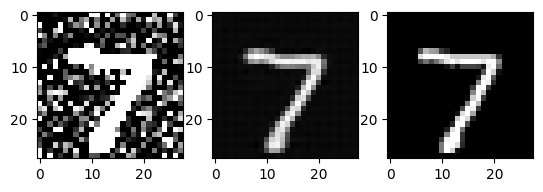

In [56]:
model.cpu()
model.eval()
with torch.no_grad():
    img = test_data.data[0]
    noise = gaussian_noise(img) #28,28

    input = torch.unsqueeze(noise,dim=0)
    input.type(torch.FloatTensor)
    input.to(device)
    input = torch.unsqueeze(input,dim=0)

    plt.subplot(1,3,1)
    plt.imshow(torch.squeeze(noise),cmap='gray')
    plt.subplot(1,3,2)
    plt.imshow(torch.squeeze(model(input)),cmap='gray')
    plt.subplot(1,3,3)
    plt.imshow(torch.squeeze(img),cmap='gray')
    plt.imshow()